Note bellow that the matplolib magic used is **inline** in order to get the plots on the html rendering of the notebook on gitlab. When running it it should be change for **notebook** in order to have the intaractive widgets further down. May also needs to be ran twice.

In [1]:
from IPython.core.display import display, HTML, Markdown

display(HTML("<style>.rendered_html { font-size: 17px; }</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_20406/2825939405.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
from cpymad.madx import Madx
import pandas as pd
import numpy as np 
from scipy.constants import c
from scipy.optimize import minimize
import pybt
import ipywidgets as widgets


plt.ion()

## incoming line

Here we find the periodic parameters for a simple FODO arangmenet, and then plot those

In [3]:
pc = 100 #GeV/c
b_rho = pc/c*1e9
beta_rel = (pc/0.938272)/np.sqrt((pc/0.938272)**2+1)
cell_length = 30 #m
quad_k = 20/b_rho # m-2
quad_length = cell_length*2/100 #m
drift_length = (cell_length-4*quad_k)/2

epsx = 1e-6
epsy = 1e-6 
dpp = 0 


madx = Madx()
madx.beam(particle='proton', pc=pc)

madx.command.quadrupole.clone('QF', l=quad_length, k1=quad_k)
madx.command.quadrupole.clone('QD', l=quad_length, k1=-quad_k)
madx.command.drift.clone('D1', l=drift_length)


madx.input('FODO: LINE=(QF, QF, D1 ,QD,QD, D1)')

madx.use(period='fodo')
twiss_periodic = madx.twiss()


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.00  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2023.05.05               +
  + Execution date: 2023.09.10 14:11:49      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
       32.16016603                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
      0.1906946087      -0.2173326893        53.61947504                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0       0.1906946087 

               dq2            betymax              dymax 

In [4]:
def plot_this_twiss(fig, twiss, twiss_interpolated=None, epsx=1e-6, epsy=1e-6, dpp=1e-3):
    if twiss_interpolated is None:
        twiss_interpolated = twiss
            
    mask = np.zeros(len(twiss_interpolated), dtype=bool)
    for index, (name, row) in enumerate(twiss_interpolated.iterrows()):
        if row['keyword']=='matrix':
            if twiss_interpolated.iloc[index+1]['name']==row['name']:
                mask[index] = True
            
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[1, 4, 4])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax3 = fig.add_subplot(gs[2], sharex=ax1)

    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)

    # top plot is synoptic
    ax1.axis('off')
    ax1.set_ylim(-1.2, 1)
    ax1.plot([0, twiss['s'].max()], [0, 0], 'k-')

    for _, row in twiss[twiss['keyword'].str.contains('quadrupole|rbend|sbend|matrix|monitor')].iterrows():
        if row['keyword'] == 'quadrupole':
            _ = ax1.add_patch(
                mpl.patches.Rectangle(
                    (row['s']-row['l'], 0), row['l'], np.sign(row['k1l']),
                    facecolor='k', edgecolor='k'))
        elif (row['keyword'] == 'rbend' or 
              row['keyword'] == 'sbend' or
              row['keyword'] == 'matrix'):
            _ = ax1.add_patch(
                mpl.patches.Rectangle(
                    (row['s']-row['l'], -1), row['l'], 2,
                    facecolor='None', edgecolor='k'))
        elif row['keyword'] == 'marker':
            _ = ax1.add_patch(
                mpl.patches.Rectangle(
                    (row['s'], -1), row['l'], 2,
                    facecolor='None', edgecolor='k'))
        elif row['keyword'] == 'monitor':
            _ = ax1.add_patch(
                mpl.patches.Rectangle(
                    (row['s'], -1), row['l'], 2,
                    facecolor='None', edgecolor='r'))
            
        

    #2nd plot is beta functions
    ax2.set_ylabel(r'$\beta$ (m)')
    betx, = ax2.plot(twiss_interpolated['s'], twiss_interpolated['betx'], 'r-')
    bety, = ax2.plot(twiss_interpolated['s'], twiss_interpolated['bety'], 'b-')        

    #3rd is beam size
    ax3.set_ylabel(r'$\sigma$ (mm)')
    sigmax, = ax3.plot(twiss_interpolated['s'], sigma(twiss_interpolated['betx'], epsx, twiss_interpolated['dx']*beta_rel, dpp)*1e3, 'r-')
    sigmay, = ax3.plot(twiss_interpolated['s'], sigma(twiss_interpolated['bety'], epsy, twiss_interpolated['dy']*beta_rel, dpp)*1e3, 'b-')        


    axnames = ax1.twiny()
    axnames.spines['top'].set_visible(False)
    axnames.spines['left'].set_visible(False)
    axnames.spines['right'].set_visible(False)
    ax1.get_shared_x_axes()

    ticks, ticks_labels = list(), list()
    for keyword in ['quadrupole', 'rbend', 'sbend', 'marker', 'matrix', 'srotation']:
        sub_twiss = twiss[twiss['keyword'] == keyword]
        ticks += list(sub_twiss['s']-sub_twiss['l']/2)
        ticks_labels += list(sub_twiss.index)

    axnames.set_xticks(ticks)
    axnames.set_xticklabels(ticks_labels, rotation=45, ha='left')

    ax3.set_xlabel('s (m)')

    fig.tight_layout()
    fig.subplots_adjust(hspace=0)
    ax1.set_xlim(twiss['s'].min(), twiss['s'].max())
    
    return betx, bety, sigmax, sigmay
    
sigma = lambda beta, eps, d, dpp : np.sqrt(beta*eps + (d*dpp)**2)

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
       32.16016603                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
      0.1906946087      -0.2173326893        53.61947504                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0       0.1906946087 

               dq2            betymax              dymax              dyrms 
     -0.2173326893        53.61947504                 -0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

(<matplotlib.lines.Line2D at 0x7f4a9120a750>,
 <matplotlib.lines.Line2D at 0x7f4a9355ccd0>)

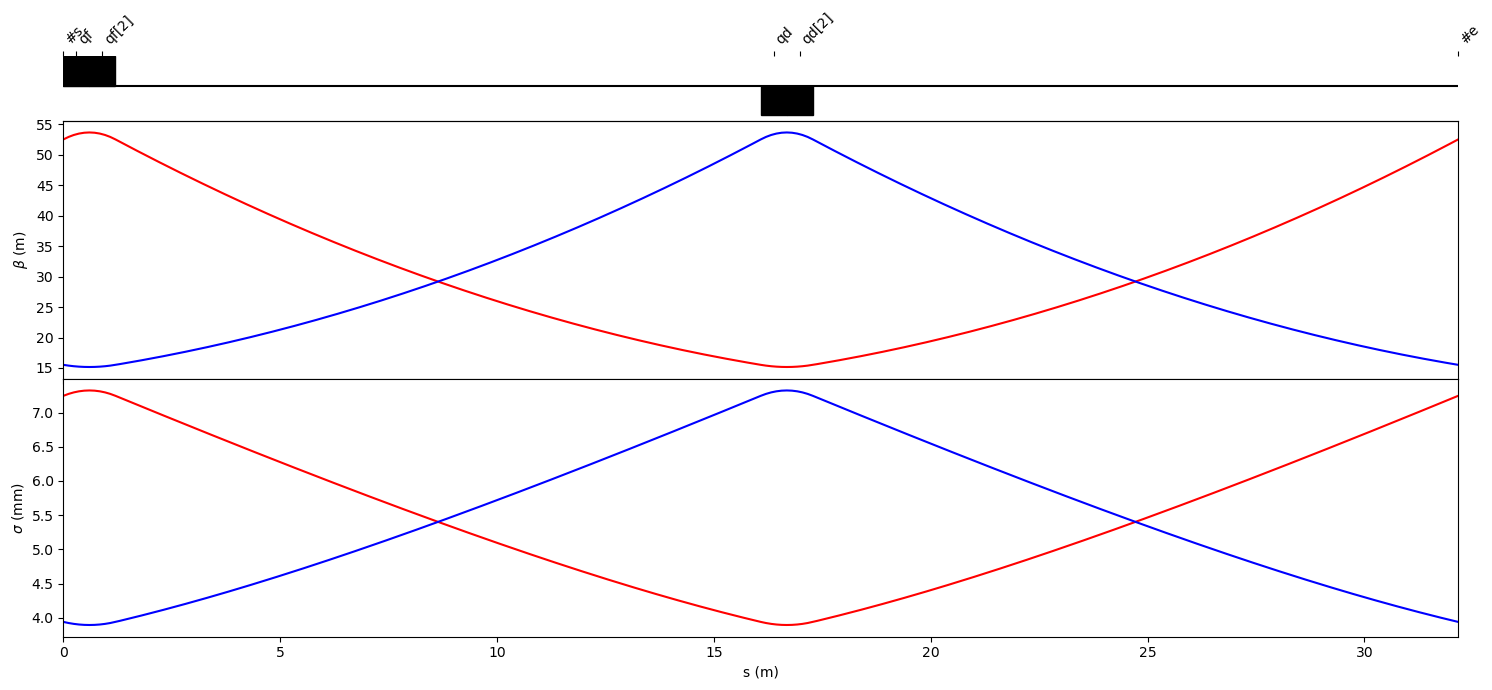

In [5]:
madx.use(sequence='fodo')
madx.select(flag='interpolate', step=0.10)
twiss_interpolated = madx.twiss().dframe()

madx.select(flag='interpolate', clear=True)
twiss = madx.twiss().dframe()

fig = plt.figure(figsize=(15,7))
plot_this_twiss(fig, twiss, twiss_interpolated, epsx, epsy, dpp)


## Beam transformation

Here we consider the beam shape at the end of the line defined above, and transform it there

In [6]:
twiss_at_end = twiss.iloc[-1]
Nparts = int(1e4)

distx = pybt.tools.particles.beam_distrib_norm(twiss_at_end['alfx'], twiss_at_end['betx'], epsx, Nparts, 4)
disty = pybt.tools.particles.beam_distrib_norm(twiss_at_end['alfy'], twiss_at_end['bety'], epsx, Nparts, 4)

distribution = pd.DataFrame({'x in':distx[:,0], 'px in':distx[:,1], 'y in':disty[:,0], 'py in':disty[:,1]})



Now let us assume that the transform is an addition to the particle's angle picked in a normal distribution centered on zero and of sigma 300urad, that we trunctae at 3sigma. For that we can use the **dpp_distrib_norm** of pybt

In [7]:
distribution['px out'] = distribution['px in'] + pybt.tools.particles.dpp_distrib_norm(300e-6, Nparts, 3)
distribution['py out'] = distribution['py in'] + pybt.tools.particles.dpp_distrib_norm(300e-6, Nparts, 3)

before the transform we had alpha=-1.8902977677991477, beta=52.47706486456274 and eps=1e-06
after the transform we have alpha=-0.8195136234767774, beta=22.539624636382584 and eps=2.3427722783329753e-06


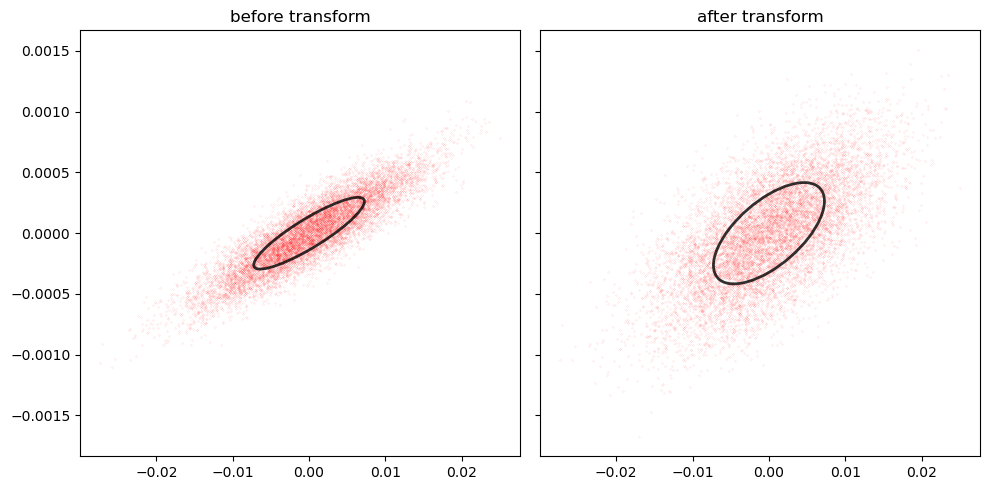

In [8]:
fig, (ax_in, ax_out) = plt.subplots(1, 2, sharex=True, sharey=True, tight_layout=True, figsize=(10, 5), num='horizontal plane')


ax_in.set_title('before transform')
ax_in.plot(distribution['x in'], distribution['px in'], 'r.', markersize=0.2, alpha=0.5)
pybt.tools.plotters.draw_ellipse(twiss_at_end['alfx'], twiss_at_end['betx'], epsx, ax=ax_in)

ax_out.set_title('after transform')
ax_out.plot(distribution['x in'], distribution['px out'], 'r.', markersize=0.2, alpha=0.5)
print('before the transform we had alpha={:}, beta={:} and eps={:}'.format(twiss_at_end['alfx'], twiss_at_end['betx'], epsx))
#since the distribution remains clean, using the second moments is good enough to get a usefull value of the emittance and planes's correlations
parms_x = pybt.tools.particles.get_parms(distribution['x in'], distribution['px out'])
pybt.tools.plotters.draw_ellipse(parms_x['alpha'], parms_x['beta'], parms_x['eps'], ax=ax_out)
print('after the transform we have alpha={:}, beta={:} and eps={:}'.format(parms_x['alpha'], parms_x['beta'], parms_x['eps']))


before the transform we had alpha=0.5935412225108141, beta=15.517334488385844 and eps=1e-06
after the transform we have alpha=0.39472548343025626, beta=10.09448585075598 and eps=1.5359856416210464e-06


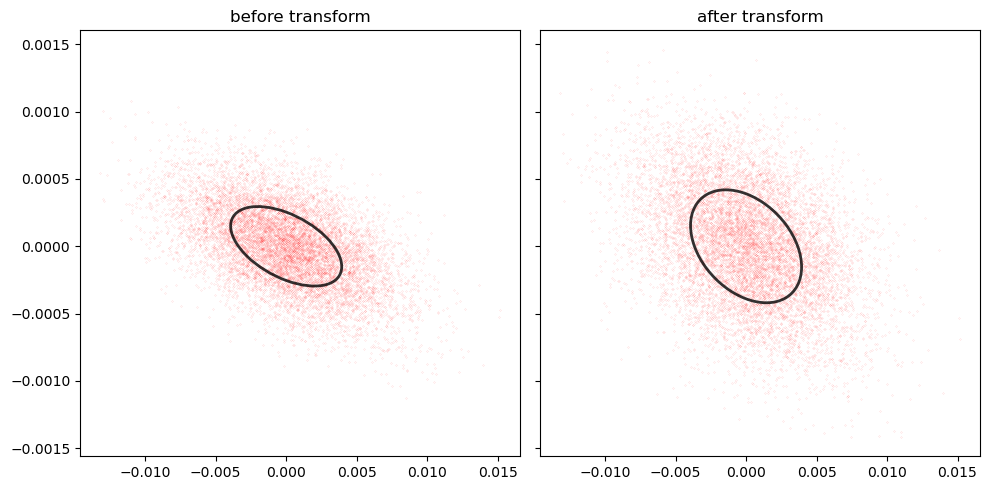

In [9]:
fig, (ax_in, ax_out) = plt.subplots(1, 2, sharex=True, sharey=True, tight_layout=True, figsize=(10, 5), num='Vertical plane')


ax_in.set_title('before transform')
ax_in.plot(distribution['y in'], distribution['py in'], 'r.', markersize=0.2, alpha=0.5)
pybt.tools.plotters.draw_ellipse(twiss_at_end['alfy'], twiss_at_end['bety'], epsy, ax=ax_in)

ax_out.set_title('after transform')
ax_out.plot(distribution['y in'], distribution['py out'], 'r.', markersize=0.2, alpha=0.5)
print('before the transform we had alpha={:}, beta={:} and eps={:}'.format(twiss_at_end['alfy'], twiss_at_end['bety'], epsx))
#since the distribution remains clean, using the second moments is good enough to get a usefull value of the emittance and planes's correlations
parms_y = pybt.tools.particles.get_parms(distribution['y in'], distribution['py out'])
pybt.tools.plotters.draw_ellipse(parms_y['alpha'], parms_y['beta'], parms_y['eps'], ax=ax_out)
print('after the transform we have alpha={:}, beta={:} and eps={:}'.format(parms_y['alpha'], parms_y['beta'], parms_y['eps']))


## beamline after the transform

Here we first use widgets to move the strength of the quadrupoles in order to find a convinient arangement

In [10]:
madx = Madx()
madx.beam(particle='proton', pc=pc)



madx.command.sequence.clone('downstream', l='{:10.6e}'.format(20))
madx.elements.marker.clone('s1start', at=0)
madx.command.endsequence()


madx.command.quadrupole.clone('Q1', l=quad_length, k1='k1')
madx.command.quadrupole.clone('Q2', l=quad_length, k1='k2')
madx.command.quadrupole.clone('Q3', l=quad_length, k1='k3')

s1, s2, s3 = 10, 11, 12
madx.command.seqedit(sequence='downstream')
madx.command.install(element='Q1', at=s1)
madx.command.install(element='Q2', at=s2)
madx.command.install(element='Q3', at=s3)
madx.command.endedit()

madx.use(sequence='downstream')

twiss = madx.twiss(betx=parms_x['beta'], bety=parms_y['beta'], alfx=parms_x['alpha'], alfy=parms_y['alpha']).dframe()




  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.00  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2023.05.05               +
  + Execution date: 2023.09.10 14:11:52      +
  ++++++++++++++++++++++++++++++++++++++++++++
++++++ info: seqedit - number of elements installed:  3
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0
enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                20                 -0                  0                  0 

                q1                d

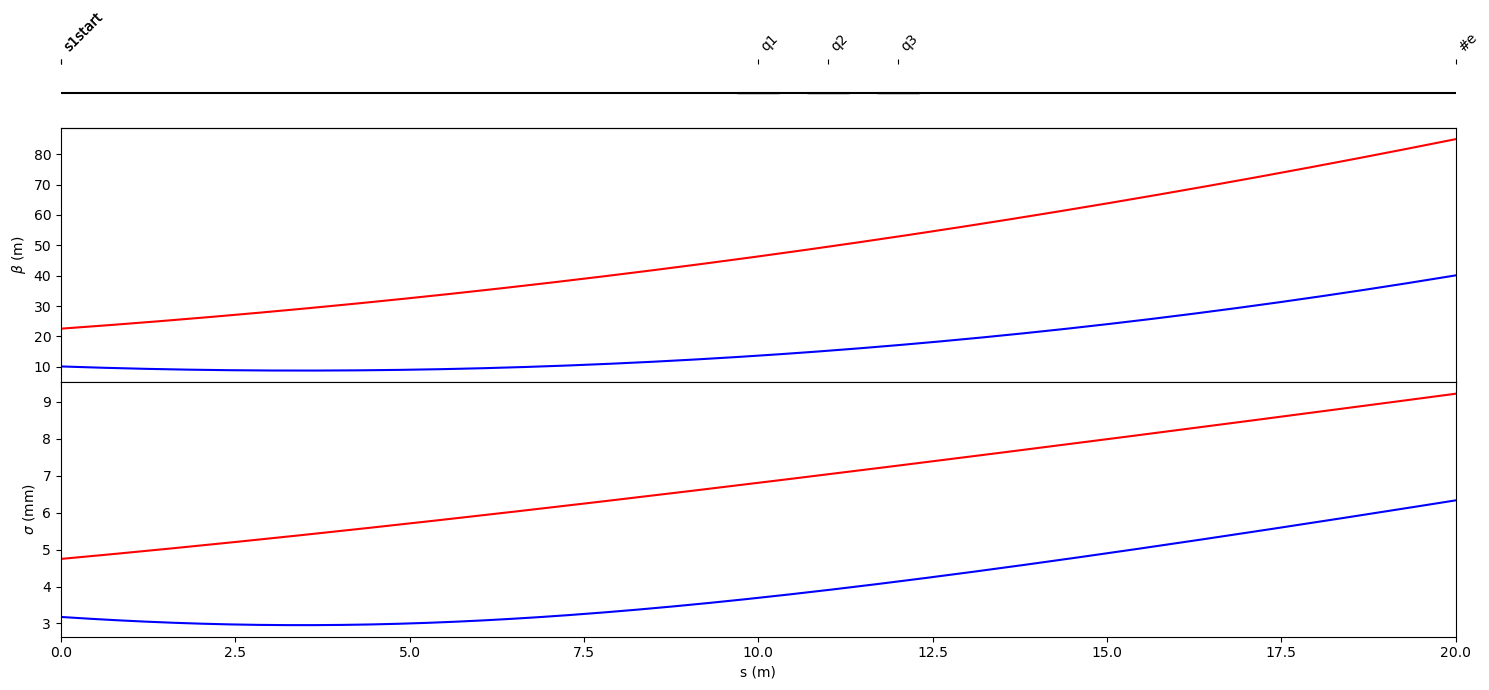

interactive(children=(FloatSlider(value=-1.4, description='k1', layout=Layout(width='600px'), max=3.0, min=-3.…

In [11]:
madx.options(twiss_print=False)

fig = plt.figure(figsize=(15,7))
madx.select(flag='interpolate', step=0.1)
twiss_interpolated = madx.twiss(betx=parms_x['beta'], bety=parms_y['beta'], alfx=parms_x['alpha'], alfy=parms_y['alpha']).dframe()
madx.select(flag='interpolate', clear=True)

betx, bety, sigmax, sigmay = plot_this_twiss(fig, twiss, twiss_interpolated)



def update(k1, k2, k3):
   
    madx.globals['k1'] = k1
    madx.globals['k2'] = k2
    madx.globals['k3'] = k3
    
    madx.use(sequence='downstream')
    madx.select(flag='interpolate', step=0.1)
    twiss_interpolated = madx.twiss(betx=parms_x['beta'], bety=parms_y['beta'], alfx=parms_x['alpha'], alfy=parms_y['alpha']).dframe()
    madx.select(flag='interpolate', clear=True)

    betx.set_ydata(twiss_interpolated['betx'])
    bety.set_ydata(twiss_interpolated['bety'])        

    sigmax.set_ydata(sigma(twiss_interpolated['betx'], parms_x['eps'], twiss_interpolated['dx']*beta_rel, dpp)*1e3)
    sigmay.set_ydata(sigma(twiss_interpolated['bety'], parms_y['eps'], twiss_interpolated['dy']*beta_rel, dpp)*1e3)

    fig.canvas.draw_idle()
    fig.canvas.draw()
    fig.canvas.flush_events()


interactive_plot = widgets.interactive(update,
                                       k1=widgets.FloatSlider(min=-3, max=3, step=0.1, value=-1.4, layout=widgets.Layout(width='600px')),
                                       k2=widgets.FloatSlider(min=-3, max=3, step=0.1, value=1.9, layout=widgets.Layout(width='600px')),
                                       k3=widgets.FloatSlider(min=-3, max=3, step=0.1, value=-1.4, layout=widgets.Layout(width='600px')))

                                       
interactive_plot    

#update(-1.4, 1.9, -1.4)


## final optimisation

Now that we have an design we like, we can switch to an optimizer to find the optimal values

In [12]:
def func(ks):
    madx.globals['k1'] = ks[0]
    madx.globals['k2'] = ks[1]
    madx.globals['k3'] = ks[2]
    
    madx.use(sequence='downstream')
    madx.select(flag='interpolate', clear=True)
    twiss = madx.twiss(betx=parms_x['beta'], bety=parms_y['beta'], alfx=parms_x['alpha'], alfy=parms_y['alpha']).dframe()
    
    twiss_end = twiss.iloc[-1]
    
    sigma_x = sigma(twiss_end['betx'], parms_x['eps'], twiss_end['dx']*beta_rel, dpp)*1e3
    sigma_y = sigma(twiss_end['bety'], parms_y['eps'], twiss_end['dy']*beta_rel, dpp)*1e3
    
    sigma_xy = np.sqrt(sigma_x**2+sigma_y**2)
    
#     print('{:5.2f} {:5.2f} {:5.2f} {:5.2f} '.format(*ks, sigma_xy))
    
    return sigma_xy

In [13]:
madx.option(twiss_print=False, warn=False)
bnds = ((-3, 3),(-3, 3),(-3, 3))
res = minimize(func, bounds=bnds, x0=[madx.globals['k1'], madx.globals['k2'], madx.globals['k3']])



In [14]:
print(res)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 1.656669150634456
        x: [-3.000e+00  2.417e+00 -1.774e+00]
      nit: 27
      jac: [ 6.678e-01 -7.327e-06 -1.288e-06]
     nfev: 136
     njev: 34
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


(<matplotlib.lines.Line2D at 0x7f4a6cd63350>,
 <matplotlib.lines.Line2D at 0x7f4a6cd7aa90>)

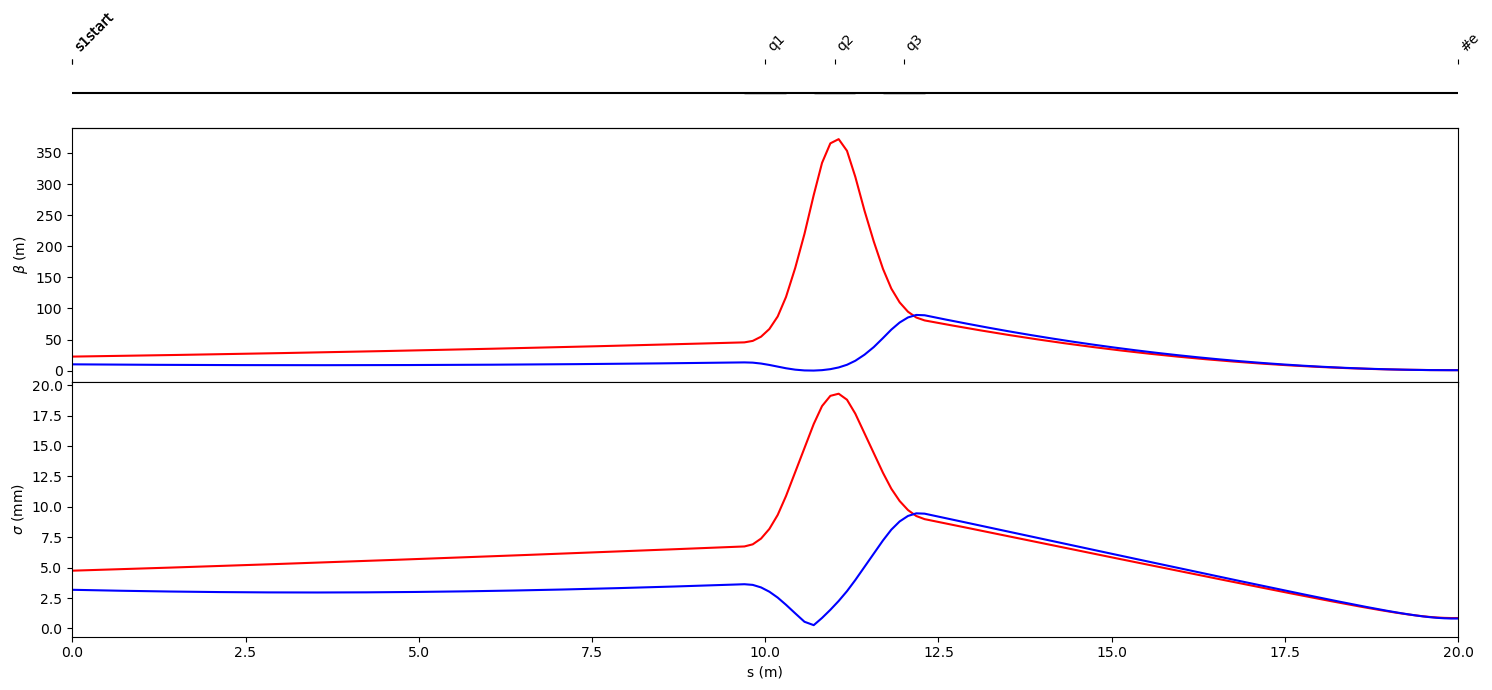

In [15]:
madx.use(sequence='downstream')
madx.select(flag='interpolate', step=0.1)
madx.input('twiss, betx={:}, bety={:}, alfx={:}, alfy={:}, save'.format(parms_x['beta'], parms_y['beta'], parms_x['alpha'], parms_y['alpha']))
twiss_interpolated = madx.sequence['downstream'].twiss_table.dframe()



fig = plt.figure(figsize=(15,7))
plot_this_twiss(fig, twiss, twiss_interpolated)
